In [195]:
import numpy as np

from matrix_computations_helper import plot_matrices

## Question 1
Suppose $A$ is an $n\times n$ upper triangular matrix, calculate $A^2$ in-place.

In [196]:
def upper_triangular_square(A):
    n = A.shape[0]
    for i in range(0, n):
        for j in range(n - 1, i - 1, -1):
            A[i, j] = A[i, :] @ A[:, j]

n = 1000
A = np.triu(np.random.rand(n, n))
A_squared_correct = A @ A
upper_triangular_square(A)
print(np.allclose(A, A_squared_correct))

True


## Question 2

Suppose $A$ is an $n\times n$ upper Hessenberg matrix and $\lambda_1,\dots,\lambda_r$ are given scalars. Compute the first column of $(A-\lambda_1I)\dots(A-\lambda_rI)$, where $r \ll n$.

In [197]:
def hessenberg_multiply_naive(A, lambdas):
    n, r = A.shape[0], len(lambdas)
    I = np.eye(n, n)
    y = I[:, 0]

    for j in range(r - 1, -1, -1):
        y = (A - lambdas[j] * I) @ y
    
    return y

def hessenberg_multiply(A, lambdas):
    n, r = A.shape[0], len(lambdas)
    I = np.eye(n, n)
    y = I[:, 0]

    for j in range(r):
        x = np.zeros(j + 2)
        for k in range(j + 1):
            for i in range(k + 2):
                if i == k:
                    x[i] = x[i] + (A[i, k] - lambdas[r - j - 1]) * y[k]
                else:
                    x[i] = x[i] + A[i, k] * y[k]
        y[0:j+2] = x

    return y
                    


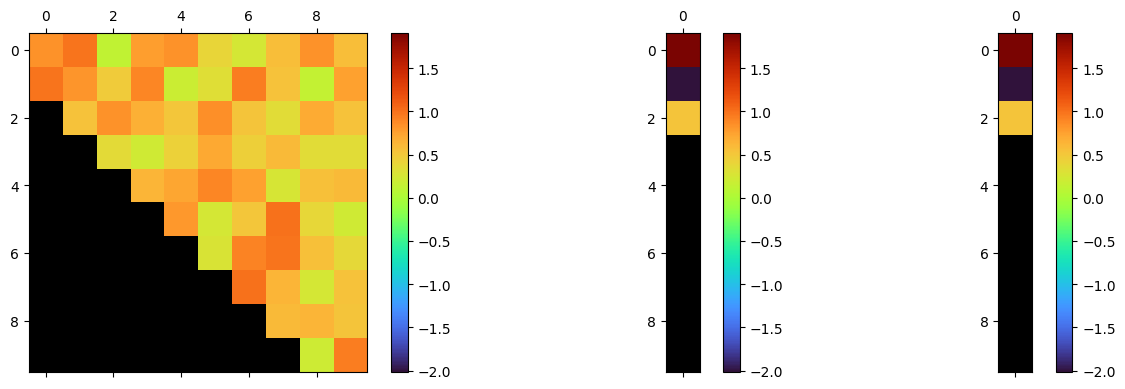

In [198]:
n = 10
r = 2
A = np.triu(np.random.rand(n, n), -1)
lambdas = np.random.randn(r)

y_correct = hessenberg_multiply_naive(A, lambdas)
y = hessenberg_multiply(A, lambdas)

plot_matrices([A, y_correct[:, np.newaxis], y[:, np.newaxis]], (1, 3), (12, 4))

## Question 3

Suppose $A$ is upper triangular and $B$ is lower triangular. Write an algorithm to for $n\times n$ matrix multiplication problem $C=C+AB$.

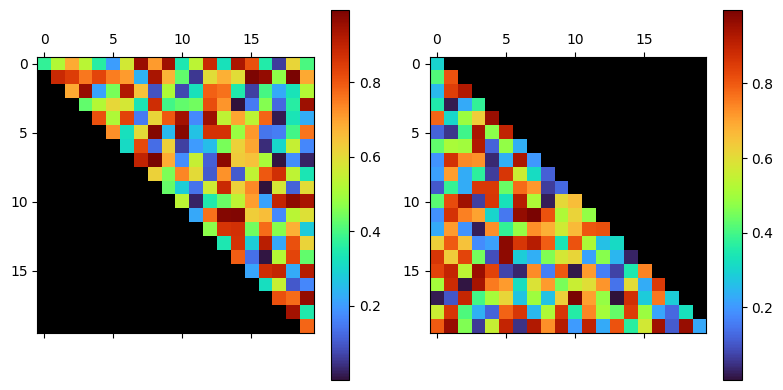

In [199]:
n = 20
A = np.triu(np.random.rand(n, n))
B = np.tril(np.random.rand(n, n))

plot_matrices([A, B], (1, 2), (8, 4), same_scale=False)

True


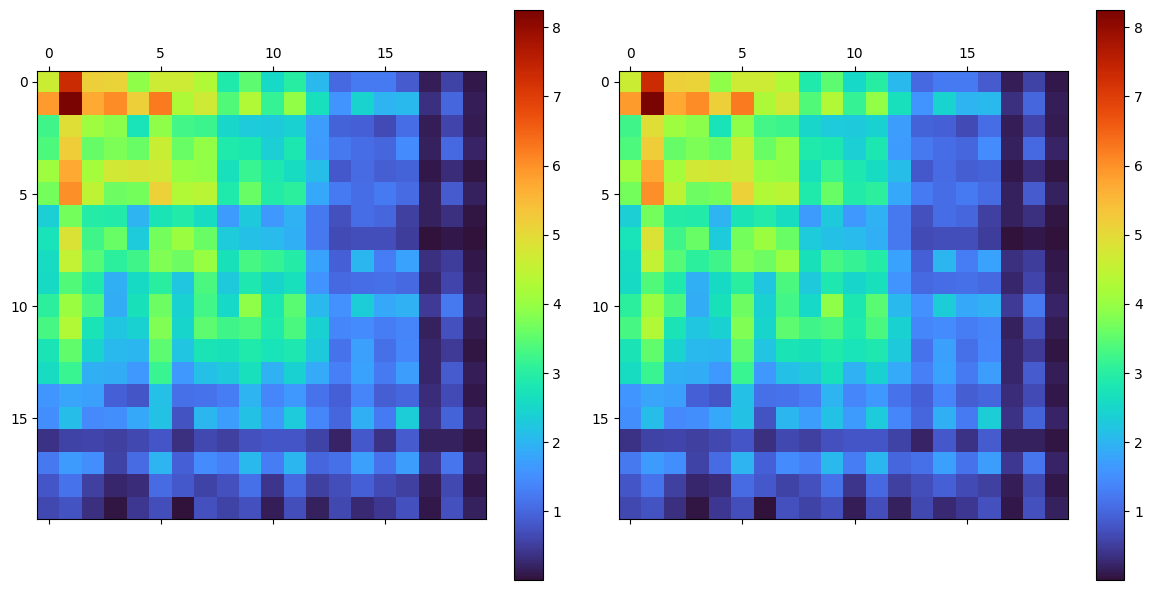

In [200]:
def upper_lower_matmul(A, B, C):
    n = A.shape[0]
    for j in range(n):
        for k in range(j, n):
            for i in range(k + 1):
                C[i, j] = C[i, j] + A[i, k] * B[k, j]

C = np.zeros((n, n))
upper_lower_matmul(A, B, C)
print(np.allclose(A @ B, C))
plot_matrices([A @ B, C], (1, 2), (12, 6))

## Question 5

If $A = B + iC$ is Hermitian with $B \in \mathbb{R}^{n \times n}$, then it is easy to show that $B^T = B$ and $C^T = -C$. Suppose we represent $A$ in an array $A.herm$ with the property that $A.herm(i,j)$ houses $b_{ij}$ if $i \geq j$ and $c_{ij}$ if $j > i$. Using this data structure, write a matrix-vector multiply function that computes $\text{Re}(z)$ and $\text{Im}(z)$ from $\text{Re}(x)$ and $\text{Im}(x)$ so that $z = Ax$.

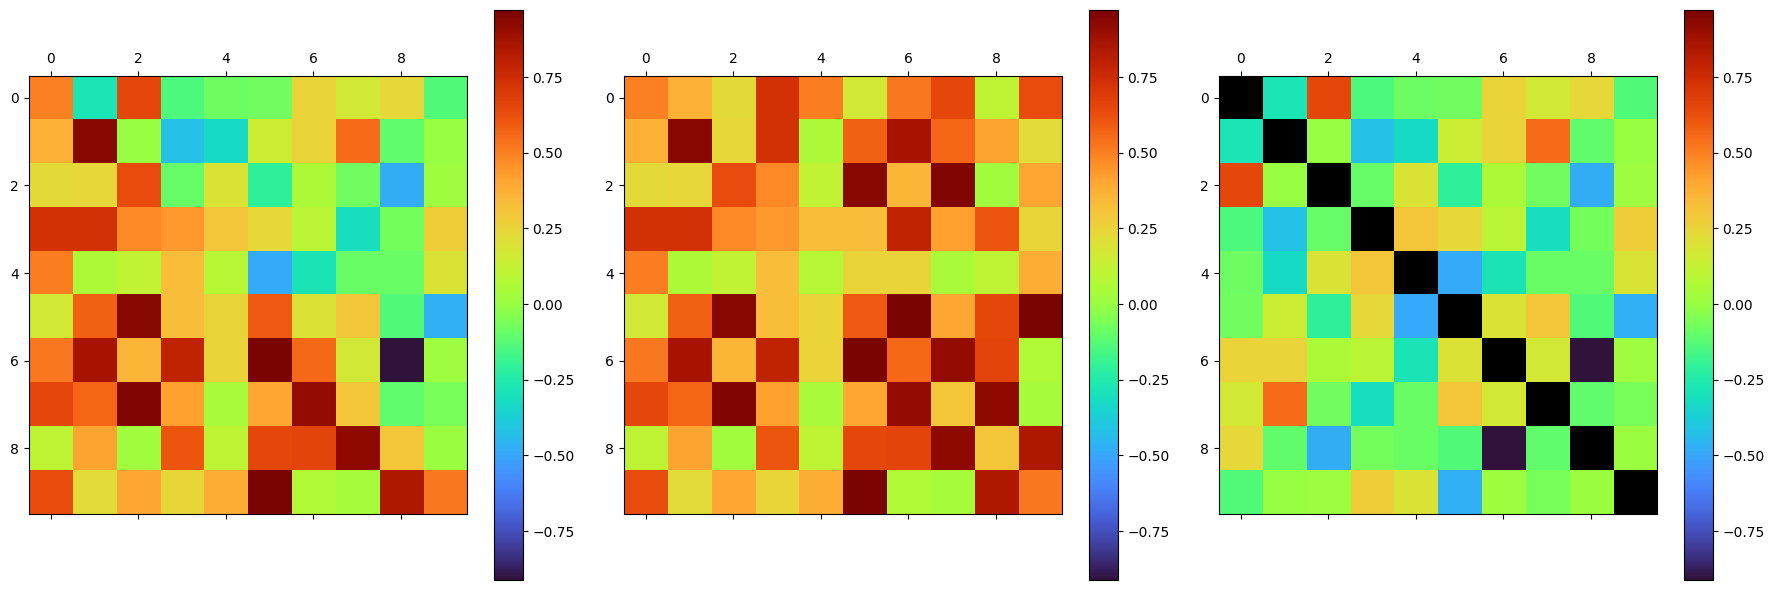

In [201]:
# Create the Hermitian structure
n = 10
B_low = np.tril(np.random.rand(n, n)) # B: i >= j
C_high = np.triu(np.random.randn(n, n), 1) * 0.3 # C: i < J
A_herm = B_low + C_high
B = np.tril(B_low, -1) + B_low.T
C = C_high + C_high.T

plot_matrices([A_herm, B, C], (1, 3), (18, 6))

In [202]:
def hermitian_saxpy(A_herm, x_re, x_im):
    n = A_herm.shape[0]
    z_re, z_im = np.zeros(n), np.zeros(n)

    for i in range(n):
        for j in range(i + 1): # j <= i
            z_re[i] = z_re[i] + A_herm[i, j] * x_re[j]
            z_im[i] = z_im[i] + A_herm[i, j] * x_im[j]
            if i != j:
                z_re[j] = z_re[j] + A_herm[i, j] * x_re[i]
                z_im[j] = z_im[j] + A_herm[i, j] * x_im[i]
        for j in range(i + 1, n): # j > i
            z_re[i] = z_re[i] - A_herm[i, j] * x_im[j]
            z_im[i] = z_im[i] + A_herm[i, j] * x_re[j]
            z_re[j] = z_re[j] - A_herm[i, j] * x_im[i]
            z_im[j] = z_im[j] + A_herm[i, j] * x_re[i]
    
    return z_re, z_im

x_re = np.random.rand(n)
x_im = np.random.rand(n)
z_re_correct = B @ x_re - C @ x_im
z_im_correct = B @ x_im + C @ x_re
z_re, z_im = hermitian_saxpy(A_herm, x_re, x_im)

print(np.allclose(z_re_correct, z_re))
print(np.allclose(z_im_correct, z_im))
            

True
True


## Question 6
Suppose $X \in \mathbb{R}^{n \times p}$ and $A \in \mathbb{R}^{n \times n}$ are given and that $A$ is symmetric. Give an algorithm for computing $B = X^T A X$ assuming that both $A$ and $B$ are to be stored using the symmetric storage.

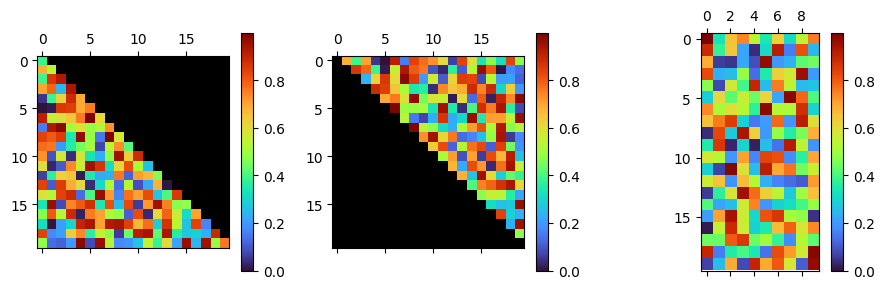

In [203]:
# Create a symmetric matrices
n = 20
p = 10
X = np.random.rand(n, p)
A_low = np.tril(np.random.rand(n, n))
A_high = np.triu(A_low.T, 1)
A = A_low + A_high

# Store A in symmetric storage
A_vec = np.empty((1 + n) * n // 2)
idx = 0
for j in range(n):
    A_vec[idx:idx+n-j] = A[j:,j]
    idx += n - j

plot_matrices([A_low, A_high, X], (1, 3), (9, 3))

In [204]:
def cal_vec_idx(i, j, n):
    if i < j:
        i, j = j, i
    return (2 * n - j - 1) * j // 2 + i

def calculate_xtax(A_vec, X):
    n, p = X.shape
    XTA = np.zeros((p, n))

    # Calculate X'A (p x n * n x n = p x n)
    for i in range(0, p):
        for j in range(0, n):
            for k in range(0, n):
                XTA[i, j] += X[k, i] * A_vec[cal_vec_idx(k, j, n)]
    
    # Calculate X'AX (p x n * n * p = p x p)
    XTAX_vec = np.zeros((1 + p) * p // 2)
    for j in range(0, p):
        for i in range(j, p):
            for k in range(0, n):
                XTAX_vec[cal_vec_idx(i, j, p)] += XTA[i, k] * X[k, j]

    return XTAX_vec       
        

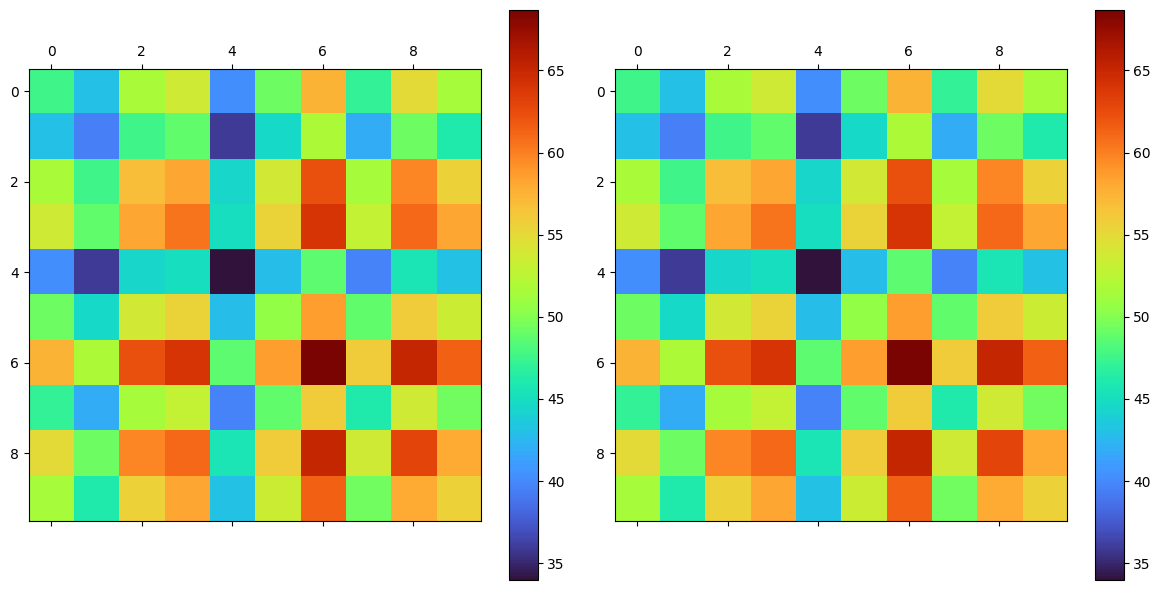

True


In [205]:
XTAX_correct = X.T @ A @ X
XTAX_vec = calculate_xtax(A_vec, X)
XTAX = np.empty((p, p))
for i in range(0, p):
    for j in range(0, p):
        XTAX[i, j] = XTAX_vec[cal_vec_idx(i, j, p)]

plot_matrices([XTAX_correct, XTAX], (1, 2), (12, 6))
print(np.allclose(XTAX_correct, XTAX))

## Question 7
Suppose $a \in \mathbb{R}^n$ is given and that $A \in \mathbb{R}^{n \times n}$ has the property that $a_{ij} = a_{|i-j|+1}$. Give an algorithm that overwrites $y$ with $y + Ax$ where $x, y \in \mathbb{R}^n$ are given.


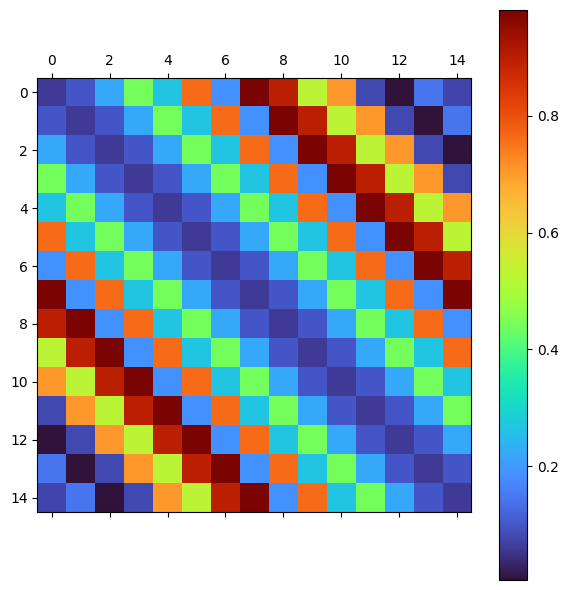

In [206]:
n = 15
a = np.random.rand(n)
A = np.empty((n, n))
x = np.random.rand(n)

for i in range(0, n):
    for j in range(0, n):
        A[i, j] = a[abs(i - j)]

plot_matrices([A], (1, 1), (6, 6))

In [207]:
def ribbon_gaxpy(a, x):
    n = a.shape[0]
    y = np.zeros(n)
    for i in range(0, n):
        y[i] = a[i:0:-1] @ x[0:i] + a[0:n-i] @ x[i:]
    return y

y_correct = A @ x
y = ribbon_gaxpy(a, x)

print(np.allclose(y_correct, y))

True


## Question 8
Suppose $a \in \mathbb{R}^n$ is given and that $A \in \mathbb{R}^{n \times n}$ has the property that $a_{ij} = a_{((i+j-1) \bmod n)+1}$. Give an algorithm that overwrites $y$ with $y + Ax$ where $x, y \in \mathbb{R}^n$ are given.


1 3 5 7 9 11 13 15 17 19 21 23 25 27 29 31 33 35 37 39 41 43 45 47 49 51 53 55 57 59 61 63 65 67 69 71 73 75 77 79 81 83 85 87 89 91 93 95 97 99 101 103 105 107 109 111 113 115 117 119 121 123 0 2 4 6 8 10 12 14 16 18 20 22 24 26 28 30 32 34 36 38 40 42 44 46 48 50 52 54 56 58 60 62 64 66 68 70 72 74 76 78 80 82 84 86 88 90 92 94 96 98 100 102 104 106 108 110 112 114 116 118 120 122 124 

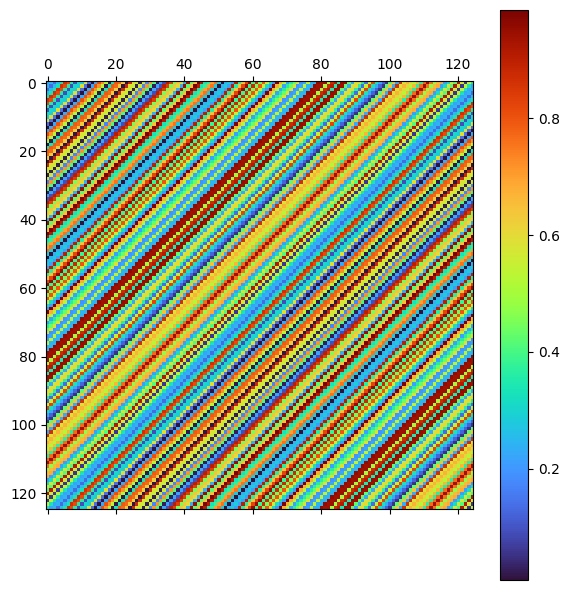

In [234]:
n = 125
a = np.random.rand(n)
A = np.empty((n, n))
x = np.random.rand(n)

for i in range(0, n):
    for j in range(0, n):
        if i == j:
            # Print index on the main diagonal
            print((i + j + 1) % n, end=' ')
        A[i, j] = a[(i + j + 1) % n]

plot_matrices([A], (1, 1), (6, 6))

In [209]:
def rev_ribbon_gaxpy(a, x):
    n = a.shape[0]
    y = np.zeros(n)
    for i in range(0, n):
        y[i] = a[i+1:n] @ x[0:n-i-1] + a[0:i+1] @ x[n-i-1:n]
    return y

y_correct = A @ x
y = rev_ribbon_gaxpy(a, x)

print(np.allclose(y_correct, y))

True


## Question 9
Develop a compact storage scheme for symmetric band matrices and write the corresponding gaxpy algorithm.

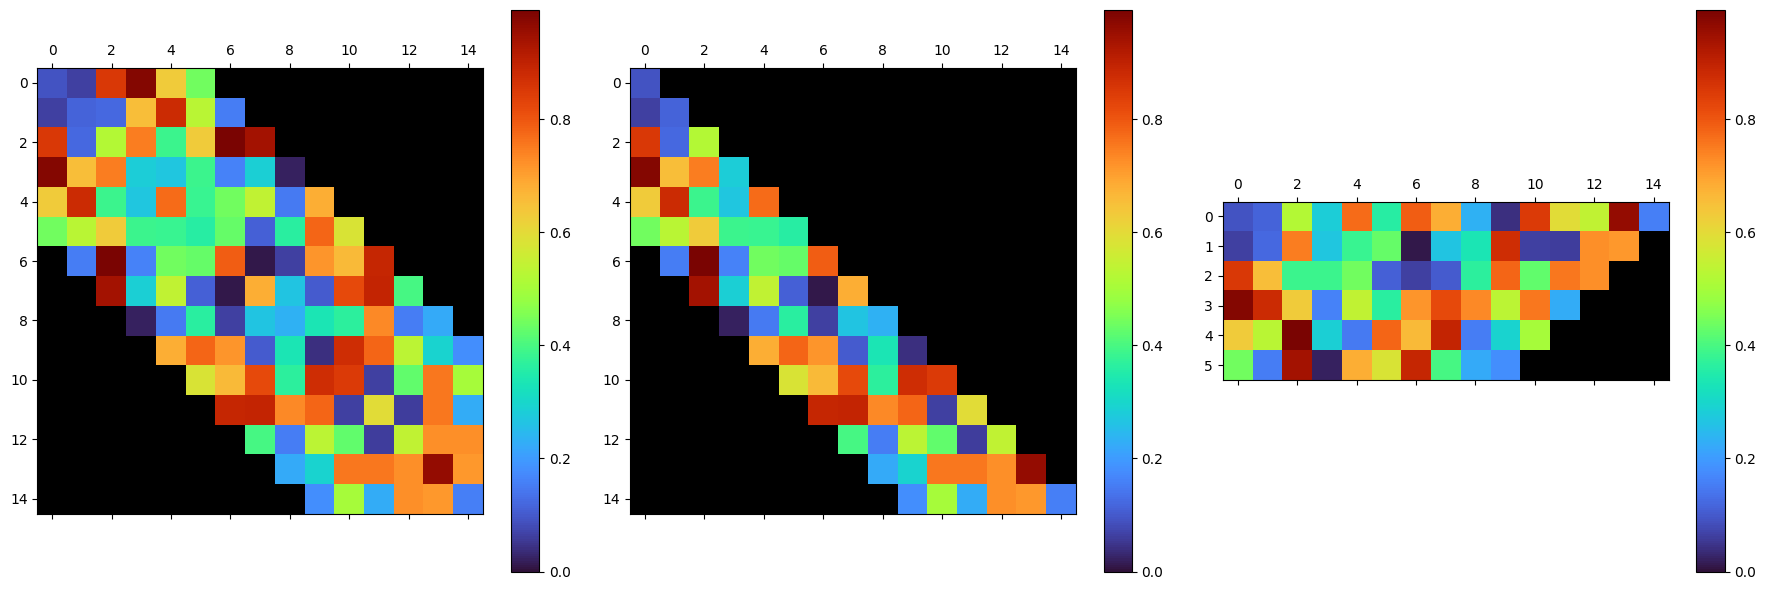

In [247]:
n = 15
bandwidth = 5
A_low = np.tril(np.triu(np.random.rand(n, n), -bandwidth))
A = np.tril(A_low, -1).T + A_low

# Store it in a symmetric band storage
A_band = np.empty((bandwidth + 1, n))
for j in range(0, n):
    a1 = j
    a2 = min(a1 + bandwidth + 1, n)
    b1 = 0
    b2 = b1 + a2 - a1
    A_band[b1:b2, j] = A[a1:a2, j]

plot_matrices([A, A_low, A_band], (1, 3), (18, 6))

In [ ]:
def symmetric_band_gaxpy(A_band, x):
    n = x.shape[0]
    y = np.zeros(n)

    for j in range(0, n):
        a1 = j
        a2 = min(n, j+bandwidth+1)
        y[a1:a2] += A_band[0:a2-a1, j] * x[j]
    
    for i in range(0, n):
        a1 = i + 1
        a2 = min(n, i + bandwidth + 1)
        y[i] += A_band[1:1+a2-a1, i] @ x[a1:a2]

    return y

x = np.random.rand(n)
y_correct = A @ x
y = symmetric_band_gaxpy(A_band, x)
print(np.allclose(y_correct, y))

6


ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 6 is different from 5)